In [202]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import datetime
import time

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
%matplotlib inline

## The GE dataset

In [203]:
df = pd.read_csv("/opt/app/data/workspace/GEPrediction-OSRS/data/Rune_Data.csv")

In [204]:
df.tail()

,timestamp,Inquisitor's_armour_set,Arcane_spirit_shield,Arcane_sigil,Sanguinesti_staff_(uncharged),Dragon_hunter_lance,Dragon_claws,Craw's_bow_(u),3rd_age_kiteshield,3rd_age_full_helmet,...,Gilded_armour_set_(lg),Anglerfish,Manta_ray,Shark,Magic_logs,Smoke_battlestaff,Anguish_ornament_kit,Tormented_ornament_kit,Occult_ornament_kit,Torture_ornament_kit
175,1627689600000,549647964,98836295,103329493,57274834,49482117,60514658,19722690,35674997,22306976,...,13268044,1878,1631,962,909,976536,6233849,3737420,3887741,4356293
176,1627776000000,523954016,103109699,107000405,57216387,48492541,60486238,19299523,35674997,22306976,...,13268044,1897,1643,961,906,965007,6238265,3793001,3734153,4353147
177,1627862400000,533865516,108265184,111933717,57261956,48693517,60725262,19096577,34206000,21915784,...,13208116,1835,1669,949,916,953016,6235644,3719881,3731552,4270950
178,1627948800000,541822591,113674637,116593442,57872786,49171874,61461001,19204204,34206000,21915784,...,13208116,1828,1679,945,920,955494,6188673,3667287,3664813,4216851
179,1628035200000,536556648,119350404,121150269,58058459,49321850,62107744,19165581,33392326,21915784,...,13223477,1802,1663,937,917,964409,6191429,3582040,3767472,4177199


In [205]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [206]:
TRAIN_SPLIT = 120

In [207]:
tf.random.set_seed(13)

## Part 1: Univariate time series

In [208]:
uni_data = df['Arcane_spirit_shield']
uni_data.index = df['timestamp']
uni_data.head()

timestamp
1612569600000    158412167
1612656000000    157849673
1612742400000    159485087
1612828800000    159742245
1612915200000    159570496
Name: Arcane_spirit_shield, dtype: int64

1628083778.575311
2021-08-04 09:29:38.575433


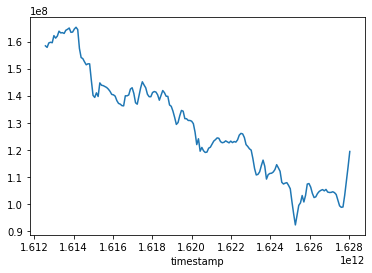

In [209]:
uni_data.plot(subplots=True)
print(time.time())
print(datetime.datetime.fromtimestamp(time.time()))

In [210]:
uni_data = uni_data.values

In [211]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [212]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [213]:
univariate_past_history = 10
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [214]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target to predict')
print (y_train_uni[0])

Single window of past history
[[1.40879348]
 [1.36749868]
 [1.48756058]
 [1.50643952]
 [1.49383078]
 [1.68579581]
 [1.61888173]
 [1.67297395]
 [1.80740799]
 [1.75978873]]

 Target to predict
1.7673442583181798


In [215]:
def create_time_steps(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)
  return time_steps

In [216]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

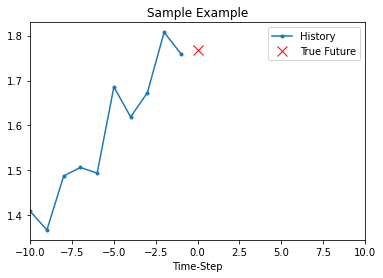

In [217]:
plot = show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')
plot.show()

### Baseline


In [218]:
def baseline(history):
  return np.mean(history)

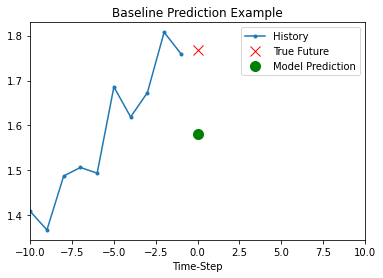

In [219]:
plot = show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')
plot.show()

### Recurrent neural network

In [220]:
BATCH_SIZE = 20
BUFFER_SIZE = 5

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [221]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [222]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(20, 1)


In [223]:
EVALUATION_INTERVAL = 500
EPOCHS = 15

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/15
500/500 [==============================] - 4s 5ms/step - loss: 0.3052 - val_loss: 1.0583
Epoch 2/15
500/500 [==============================] - 2s 4ms/step - loss: 0.1744 - val_loss: 0.8781
Epoch 3/15
500/500 [==============================] - 2s 4ms/step - loss: 0.1254 - val_loss: 0.6536
Epoch 4/15
500/500 [==============================] - 2s 4ms/step - loss: 0.0991 - val_loss: 0.4954
Epoch 5/15
500/500 [==============================] - 2s 4ms/step - loss: 0.0901 - val_loss: 0.4700
Epoch 6/15
500/500 [==============================] - 2s 4ms/step - loss: 0.0880 - val_loss: 0.4761
Epoch 7/15
500/500 [==============================] - 2s 4ms/step - loss: 0.0867 - val_loss: 0.4770
Epoch 8/15
500/500 [==============================] - 2s 4ms/step - loss: 0.0849 - val_loss: 0.5165
Epoch 9/15
500/500 [==============================] - 2s 4ms/step - loss: 0.0820 - val_loss: 0.5449
Epoch 10/15
500/500 [==============================] - 2s 4ms/step - loss: 0.0790 - val_loss: 0.5910

#### Predict using the simple LSTM model


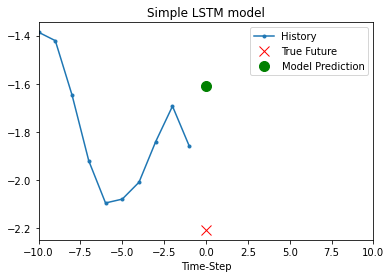

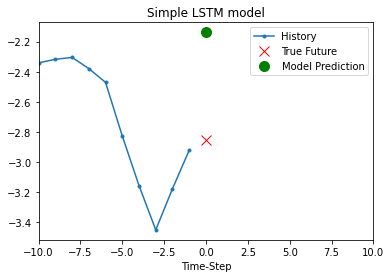

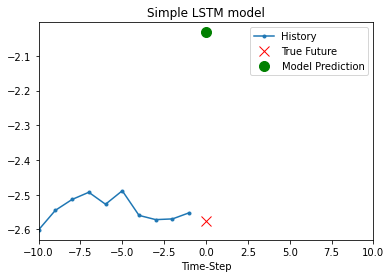

In [224]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

## Part 2: Multivariate time series

In [225]:
features_considered = ['Arcane_sigil','Sanguinesti_staff_(uncharged)','Dragon_claws']

In [226]:
features = df[features_considered]
features.index = df['timestamp']
features.head()

,Arcane_sigil,Sanguinesti_staff_(uncharged),Dragon_claws
timestamp,,,
1612569600000,157846710,90576206,58397545
1612656000000,157846710,90911736,58375225
1612742400000,157846710,89566903,58412141
1612828800000,157403161,89598655,58271575
1612915200000,157403161,90447500,58044464


array([<AxesSubplot:xlabel='timestamp'>, <AxesSubplot:xlabel='timestamp'>,
       <AxesSubplot:xlabel='timestamp'>], dtype=object)

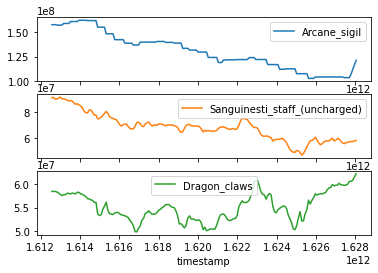

In [227]:
features.plot(subplots=True)

In [228]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [229]:
dataset = (dataset-data_mean)/data_std

### Single step model

In [230]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [231]:
past_history = 10
future_target = 1
STEP = 1

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [232]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (10, 3)


In [233]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [234]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [235]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(20, 1)


In [236]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/15
500/500 [==============================] - 4s 5ms/step - loss: 0.2400 - val_loss: 1.2845
Epoch 2/15
500/500 [==============================] - 2s 4ms/step - loss: 0.1526 - val_loss: 1.5624
Epoch 3/15
500/500 [==============================] - 2s 4ms/step - loss: 0.1284 - val_loss: 1.5764
Epoch 4/15
500/500 [==============================] - 2s 4ms/step - loss: 0.1128 - val_loss: 1.6663
Epoch 5/15
500/500 [==============================] - 2s 5ms/step - loss: 0.0944 - val_loss: 1.6995
Epoch 6/15
500/500 [==============================] - 2s 4ms/step - loss: 0.0797 - val_loss: 1.6742
Epoch 7/15
500/500 [==============================] - 2s 5ms/step - loss: 0.0706 - val_loss: 1.6457
Epoch 8/15
500/500 [==============================] - 2s 4ms/step - loss: 0.0608 - val_loss: 1.6919
Epoch 9/15
500/500 [==============================] - 2s 4ms/step - loss: 0.0545 - val_loss: 1.7258
Epoch 10/15
500/500 [==============================] - 2s 4ms/step - loss: 0.0490 - val_loss: 1.7414

In [237]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

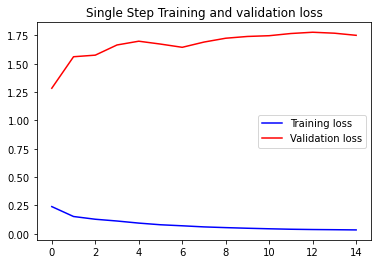

In [238]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

#### Predict a single step future

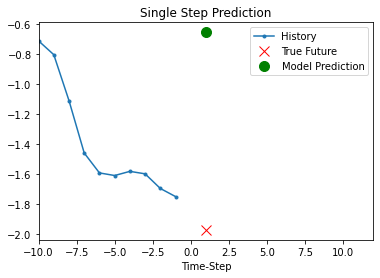

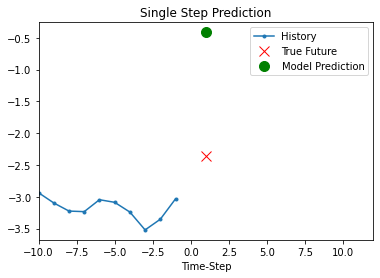

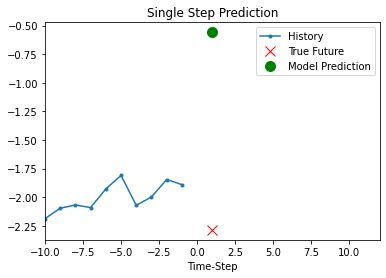

In [239]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 1,
                   'Single Step Prediction')
  plot.show()

### Multi-Step model

In [240]:
future_target = 5
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [241]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (10, 3)

 Target temperature to predict : (5,)


In [242]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [243]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

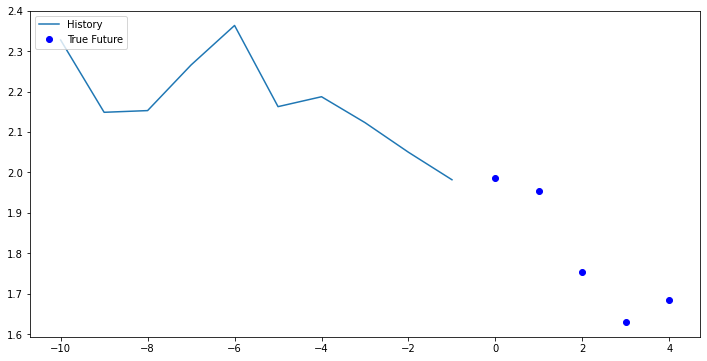

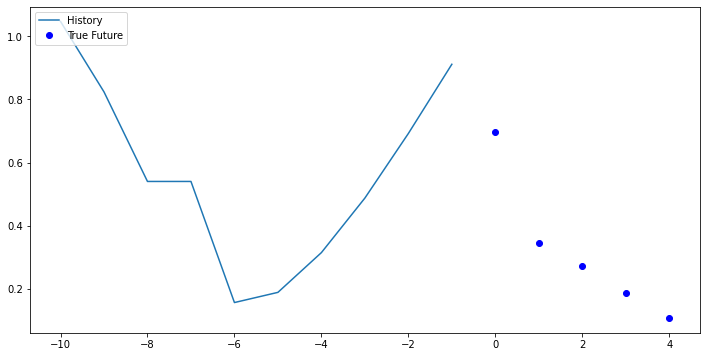

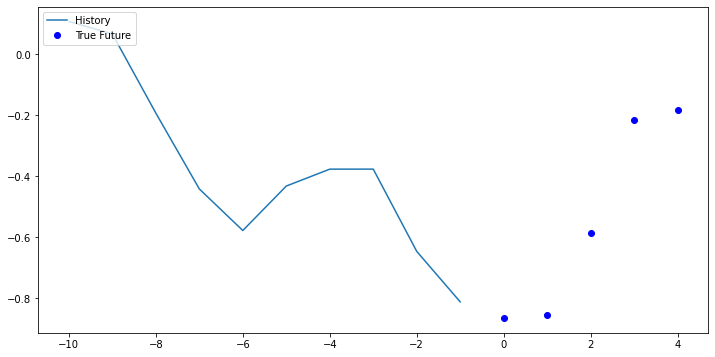

In [250]:
for x, y in train_data_multi.take(3):
  multi_step_plot(x[0], y[0], np.array([0]))

In [245]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
# multi_step_model.add(tf.keras.layers.Dense(72))
multi_step_model.add(tf.keras.layers.Dense(future_target))


multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [246]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

(20, 5)


In [247]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/15
500/500 [==============================] - 6s 8ms/step - loss: 0.2824 - val_loss: 1.2874
Epoch 2/15
500/500 [==============================] - 3s 7ms/step - loss: 0.1853 - val_loss: 1.6661
Epoch 3/15
500/500 [==============================] - 3s 7ms/step - loss: 0.1519 - val_loss: 2.1637
Epoch 4/15
500/500 [==============================] - 3s 7ms/step - loss: 0.1339 - val_loss: 2.1915
Epoch 5/15
500/500 [==============================] - 3s 7ms/step - loss: 0.1170 - val_loss: 2.2838
Epoch 6/15
500/500 [==============================] - 3s 7ms/step - loss: 0.1080 - val_loss: 2.7771
Epoch 7/15
500/500 [==============================] - 3s 7ms/step - loss: 0.1023 - val_loss: 2.3932
Epoch 8/15
500/500 [==============================] - 3s 7ms/step - loss: 0.0967 - val_loss: 2.2169
Epoch 9/15
500/500 [==============================] - 3s 7ms/step - loss: 0.0912 - val_loss: 2.3078
Epoch 10/15
500/500 [==============================] - 3s 7ms/step - loss: 0.0863 - val_loss: 2.1511

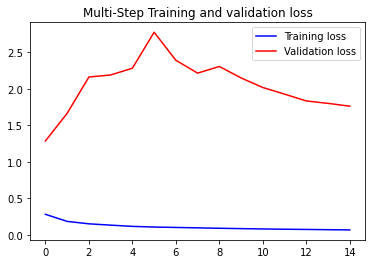

In [248]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

#### Predict a multi-step future

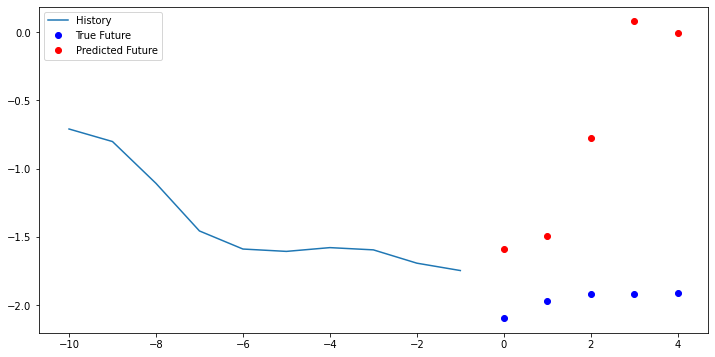

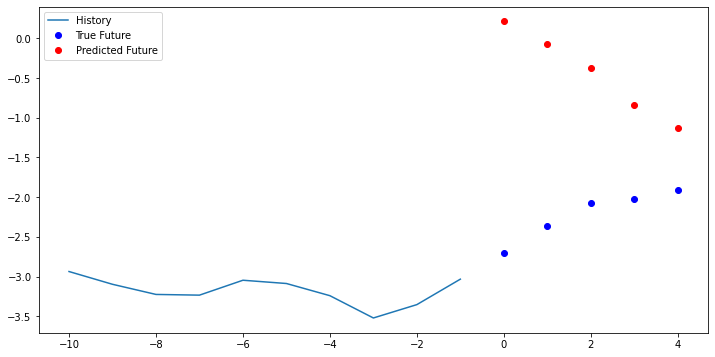

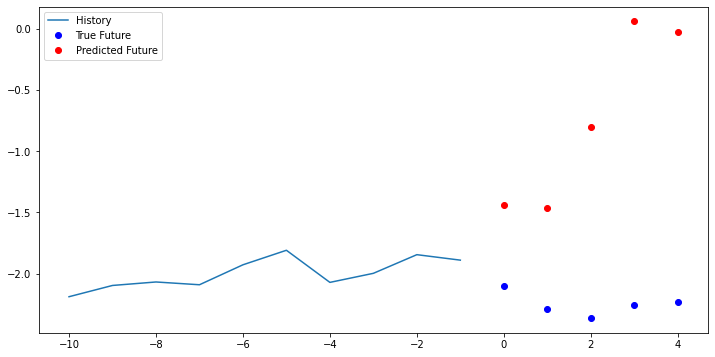

In [249]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])